# Search best predicted subregions of the stark enhancers

In [ ]:
import os
import pandas as pd
import numpy as np
import anndata
import crested
import keras

In [ ]:
genome_path = "../../../../../../../../eceksi/resources/dmel/no_chr/dm6_nochr_filtered.fa"
hydrop_coverage_bw_path = "../../../../../../../data/hydrop/fly_embryo/paper_zips/10x_hydropv2_comparisons_data/bigwigs/hydrop/"
adata_multiome_path = "../../../../../../../data/hydrop/fly_embryo/paper_zips/10x_hydropv2_comparisons_data/anndatas/10x_fly_kfolds.h5ad" 
hydrop_models_path = "../../../../../../../data/hydrop/fly_embryo/paper_zips/10x_hydropv2_comparisons_models/hydrop_fly"
multiome_models_path = "../../../../../../../data/hydrop/fly_embryo/paper_zips/10x_hydropv2_comparisons_models/10x_fly"

In [3]:
genome = crested.Genome(genome_path)
crested.register_genome(genome)

2025-03-19T21:12:19.486937+0100 INFO Genome dm6_nochr_filtered registered.


In [4]:
# only need this for the obs_names
adata = anndata.read_h5ad(adata_multiome_path)

In [5]:
adata.obs_names

Index(['Epidermis', 'Fat_body', 'Glia', 'Head_Ectoderm', 'Hemocytes',
       'Hindgut', 'Malpighian_tubule', 'Midgut', 'Midgut_acidification',
       'Neuroblasts', 'Neuronal', 'PNS_sens_neurons', 'Pharnyx',
       'Primordium_all', 'Salivary_gland', 'Somatic_muscles',
       'Tracheal_system', 'Visceral_muscles', 'Yolk',
       'muscle_attachement_Stripe'],
      dtype='object')

In [6]:
hydrop_models = []
for model in os.listdir(hydrop_models_path):
    hydrop_models.append(keras.models.load_model(os.path.join(hydrop_models_path, model)))

multiome_models = []
for model in os.listdir(multiome_models_path):
    multiome_models.append(keras.models.load_model(os.path.join(multiome_models_path, model)))

I0000 00:00:1742415156.030446 2334419 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38435 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB MIG 3g.40gb, pci bus id: 0000:25:00.0, compute capability: 8.0


In [7]:
# find best predicted subpart of each enhancer accross the cell types
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

def get_best_subregion(chrom, start, end, model, cell_types, adata, enhancer_width=500, step=1):
    """Returns chrom, start, end of highest predicted subregion of the enhancer."""
    full_seq = genome.fetch(chrom, start, end).upper()
    enhancer_full_length = end-start
    enhancer_subregions = []

    for i in range(0, enhancer_full_length-enhancer_width, step):
        enhancer_subregions.append(full_seq[i:i+enhancer_width])

    predictions = crested.tl.predict(enhancer_subregions, model) # (N, num_classes)  

    class_indices = list(adata.obs_names.get_indexer(cell_types))

    # sum the predictions for the target cell types
    sum_predictions = np.sum(predictions[:, class_indices], axis=1) # (N,)
    best_subregion_idx = np.argmax(sum_predictions)

    best_subregion_start = int(start + best_subregion_idx*step)
    best_subregion_end = int(best_subregion_start + enhancer_width)

    return chrom, best_subregion_start, best_subregion_end, sum_predictions


def plot_region_predictions_folds(preds_hydrop_folds, preds_multiome_folds, id: str, region_name: str, smooth_window: int = 25):
    # Convert to NumPy arrays (shape: [n_folds, region_length])
    preds_hydrop_folds = np.array(preds_hydrop_folds)
    preds_multiome_folds = np.array(preds_multiome_folds)

    # Compute mean and standard deviation across folds
    preds_hydrop_mean = np.mean(preds_hydrop_folds, axis=0)
    preds_hydrop_std = np.std(preds_hydrop_folds, axis=0)
    
    preds_multiome_mean = np.mean(preds_multiome_folds, axis=0)
    preds_multiome_std = np.std(preds_multiome_folds, axis=0)

    # Compute the 95% confidence interval (1.96 * std)
    ci_95_hydrop = 1.96 * preds_hydrop_std
    ci_95_multiome = 1.96 * preds_multiome_std

    # Apply smoothing
    preds_hydrop_smooth = np.convolve(preds_hydrop_mean, np.ones(smooth_window) / smooth_window, mode='same')
    preds_multiome_smooth = np.convolve(preds_multiome_mean, np.ones(smooth_window) / smooth_window, mode='same')
    
    ci_95_hydrop_smooth = np.convolve(ci_95_hydrop, np.ones(smooth_window) / smooth_window, mode='same')
    ci_95_multiome_smooth = np.convolve(ci_95_multiome, np.ones(smooth_window) / smooth_window, mode='same')

    # Define genomic positions
    len_region = preds_hydrop_mean.shape[0]
    genomic_positions = np.arange(0, len_region)

    # Create a DataFrame for Seaborn
    df = pd.DataFrame({
        "Genomic Position": np.tile(genomic_positions, 2),
        "Prediction Score": np.concatenate([preds_hydrop_smooth, preds_multiome_smooth]),
        "Model": ["HyDrop (Mean)"] * len_region + ["10x (Mean)"] * len_region
    })

    # Set up the plot
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df, x="Genomic Position", y="Prediction Score", hue="Model", linewidth=1.5, palette=['#E69F00', '#0072BB'])

    # Add confidence interval shading (95% CI)
    plt.fill_between(genomic_positions, 
                     preds_hydrop_smooth - ci_95_hydrop_smooth, 
                     preds_hydrop_smooth + ci_95_hydrop_smooth, 
                     color='#E69F00', alpha=0.2, label="HyDrop 95% CI")

    plt.fill_between(genomic_positions, 
                     preds_multiome_smooth - ci_95_multiome_smooth, 
                     preds_multiome_smooth + ci_95_multiome_smooth, 
                     color='#0072BB', alpha=0.2, label="10x 95% CI")

    # Labels and title
    plt.xlabel("bp")
    plt.ylabel("Predicted accessibility")
    plt.title(f"{id} - {region_name}")
    plt.legend(title=None)

    # Save the plot
    save_path = f"../data/results/stark_enhancers_lineplots/{id}_{region_name}.png"
    svg_path = f"../data/results/stark_enhancers_lineplots/{id}_{region_name}.svg"
    pdf_path = f"../data/results/stark_enhancers_lineplots/{id}_{region_name}.pdf"
    plt.savefig(save_path)
    plt.savefig(svg_path)
    plt.savefig(pdf_path)
    plt.show()

In [12]:
# test
best_chr, best_start, best_end, preds_hydrop = get_best_subregion("2L", 6073895, 6076535, hydrop_models[0], ["Neuronal"], adata, step=1)

I0000 00:00:1742304319.019149 1954616 service.cc:148] XLA service 0x14b218004060 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742304319.019664 1954616 service.cc:156]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2025-03-18 14:25:20.545137: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742304323.332008 1954616 cuda_dnn.cc:530] Loaded cuDNN version 8907
2025-03-18 14:25:41.436147: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=0} for conv (f32[1,256,1,125]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,512,1,125]{3,2,1,0}, f32[256,512,1,11]{3,2,1,0}), window={size=1x11 pad=0_0x5_5}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"

 110/2140 ━━━━━━━━━━━━━━━━━━━━ 1s 928us/step

I0000 00:00:1742304344.702360 1954616 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2140/2140 ━━━━━━━━━━━━━━━━━━━━ 29s 918us/step


## VT14978

In [9]:
%matplotlib inline

In [10]:
best_subregions = []

In [11]:
region_id = "VT14978"
chrom = "2R"
start = 11194318
end = 11196390
celltypes = ["Midgut"]

In [12]:
best_chr_hydrop, best_start_hydrop, best_end_hydrop, preds_hydrop = get_best_subregion(chrom, start, end, hydrop_models, celltypes, adata, step=1)
best_subregion = f"{best_chr_hydrop}:{best_start_hydrop}-{best_end_hydrop}"
print(best_subregion)
best_subregions.append(best_subregion)

I0000 00:00:1742415272.044659 2340189 service.cc:148] XLA service 0x15531400a520 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742415272.047082 2340189 service.cc:156]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB MIG 3g.40gb, Compute Capability 8.0
2025-03-19 21:14:33.665252: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742415276.413516 2340189 cuda_dnn.cc:530] Loaded cuDNN version 8907
2025-03-19 21:14:49.762471: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 64.77GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


 177/1572 ━━━━━━━━━━━━━━━━━━━━ 1s 861us/step

I0000 00:00:1742415293.940659 2340189 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1572/1572 ━━━━━━━━━━━━━━━━━━━━ 25s 886us/step
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 2s 810us/step
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 2s 828us/step
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 2s 808us/step
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 2s 797us/step
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 2s 801us/step
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 2s 806us/step
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 2s 807us/step
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 2s 805us/step
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 2s 797us/step
2R:11195867-11196367


1572/1572 ━━━━━━━━━━━━━━━━━━━━ 2s 817us/step
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 2s 908us/step
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 2s 813us/step
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 2s 795us/step
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 2s 800us/step
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 2s 793us/step
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 2s 810us/step
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 2s 805us/step
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 2s 800us/step
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 2s 809us/step
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 1s 837us/step
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 1s 813us/step
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 1s 812us/step
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 1s 813us/step
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 1s 801us/step
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 1s 800us/step
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 1s 805us/step
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 1s 809us/step
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 1s 829us/step
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 1s 809us/step


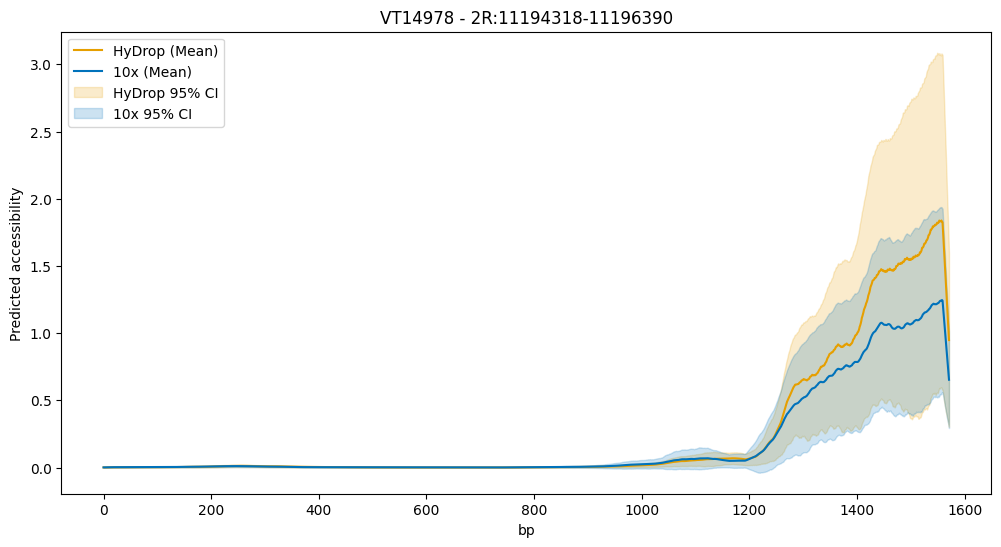

In [13]:
preds_multiome_folds = []
for model in multiome_models:
    _, _, _, preds_multiome = get_best_subregion(chrom, start, end, model, celltypes, adata, step=1)
    preds_multiome_folds.append(preds_multiome)

preds_hydrop_folds = []
for model in hydrop_models:
    _, _, _, preds_hydrop = get_best_subregion(chrom, start, end, model, celltypes, adata, step=1)
    preds_hydrop_folds.append(preds_hydrop)

plot_region_predictions_folds(preds_hydrop_folds, preds_multiome_folds, region_id, f"{chrom}:{str(start)}-{str(end)}", smooth_window=25)

## VT3067


In [14]:
region_id = "VT3067"
chrom = "2L"
start = 6073895
end = 6076535
celltypes = ["Neuronal", "Head_Ectoderm","Midgut_acidification","Neuroblasts","Midgut"]

In [15]:
best_chr_hydrop, best_start_hydrop, best_end_hydrop, preds_hydrop = get_best_subregion(chrom, start, end, hydrop_models, celltypes, adata, step=1)
best_subregion = f"{best_chr_hydrop}:{best_start_hydrop}-{best_end_hydrop}"
print(best_subregion)
best_subregions.append(best_subregion)

2140/2140 ━━━━━━━━━━━━━━━━━━━━ 2s 825us/step
2140/2140 ━━━━━━━━━━━━━━━━━━━━ 2s 804us/step
2140/2140 ━━━━━━━━━━━━━━━━━━━━ 2s 810us/step
2140/2140 ━━━━━━━━━━━━━━━━━━━━ 2s 811us/step
2140/2140 ━━━━━━━━━━━━━━━━━━━━ 2s 811us/step
2140/2140 ━━━━━━━━━━━━━━━━━━━━ 2s 825us/step
2140/2140 ━━━━━━━━━━━━━━━━━━━━ 2s 807us/step
2140/2140 ━━━━━━━━━━━━━━━━━━━━ 2s 832us/step
2140/2140 ━━━━━━━━━━━━━━━━━━━━ 2s 836us/step
2140/2140 ━━━━━━━━━━━━━━━━━━━━ 2s 811us/step
2L:6075201-6075701


2140/2140 ━━━━━━━━━━━━━━━━━━━━ 2s 800us/step
2140/2140 ━━━━━━━━━━━━━━━━━━━━ 2s 831us/step
2140/2140 ━━━━━━━━━━━━━━━━━━━━ 2s 807us/step
2140/2140 ━━━━━━━━━━━━━━━━━━━━ 2s 802us/step
2140/2140 ━━━━━━━━━━━━━━━━━━━━ 2s 804us/step
2140/2140 ━━━━━━━━━━━━━━━━━━━━ 2s 804us/step
2140/2140 ━━━━━━━━━━━━━━━━━━━━ 2s 805us/step
2140/2140 ━━━━━━━━━━━━━━━━━━━━ 2s 818us/step
2140/2140 ━━━━━━━━━━━━━━━━━━━━ 2s 808us/step
2140/2140 ━━━━━━━━━━━━━━━━━━━━ 2s 807us/step
2140/2140 ━━━━━━━━━━━━━━━━━━━━ 2s 841us/step
2140/2140 ━━━━━━━━━━━━━━━━━━━━ 2s 806us/step
2140/2140 ━━━━━━━━━━━━━━━━━━━━ 2s 821us/step
2140/2140 ━━━━━━━━━━━━━━━━━━━━ 2s 814us/step
2140/2140 ━━━━━━━━━━━━━━━━━━━━ 2s 809us/step
2140/2140 ━━━━━━━━━━━━━━━━━━━━ 2s 796us/step
2140/2140 ━━━━━━━━━━━━━━━━━━━━ 2s 806us/step
2140/2140 ━━━━━━━━━━━━━━━━━━━━ 2s 805us/step
2140/2140 ━━━━━━━━━━━━━━━━━━━━ 2s 830us/step
2140/2140 ━━━━━━━━━━━━━━━━━━━━ 2s 797us/step


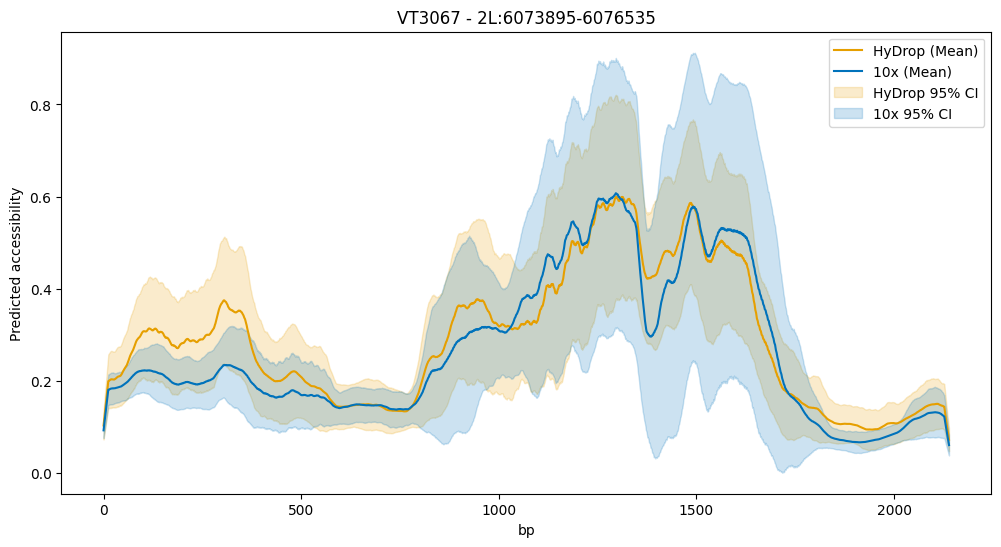

In [16]:
preds_multiome_folds = []
for model in multiome_models:
    _, _, _, preds_multiome = get_best_subregion(chrom, start, end, model, celltypes, adata, step=1)
    preds_multiome_folds.append(preds_multiome)

preds_hydrop_folds = []
for model in hydrop_models:
    _, _, _, preds_hydrop = get_best_subregion(chrom, start, end, model, celltypes, adata, step=1)
    preds_hydrop_folds.append(preds_hydrop)

plot_region_predictions_folds(preds_hydrop_folds, preds_multiome_folds, region_id, f"{chrom}:{str(start)}-{str(end)}", smooth_window=25)

## VT40610

In [17]:
region_id = "VT40610"
chrom = "3R"
start = 12644407
end = 12646146
celltypes = ["Pharnyx"]
# celltypes = ["Pharnyx","Hindgut","Midgut"]

In [18]:
best_chr_hydrop, best_start_hydrop, best_end_hydrop, preds_hydrop = get_best_subregion(chrom, start, end, multiome_models, celltypes, adata, step=1)
best_subregion = f"{best_chr_hydrop}:{best_start_hydrop}-{best_end_hydrop}"
print(best_subregion)
best_subregions.append(best_subregion)

 395/1239 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step

1239/1239 ━━━━━━━━━━━━━━━━━━━━ 1s 837us/step
1239/1239 ━━━━━━━━━━━━━━━━━━━━ 1s 829us/step
1239/1239 ━━━━━━━━━━━━━━━━━━━━ 1s 805us/step
1239/1239 ━━━━━━━━━━━━━━━━━━━━ 1s 802us/step
1239/1239 ━━━━━━━━━━━━━━━━━━━━ 1s 804us/step
1239/1239 ━━━━━━━━━━━━━━━━━━━━ 1s 795us/step
1239/1239 ━━━━━━━━━━━━━━━━━━━━ 1s 807us/step
1239/1239 ━━━━━━━━━━━━━━━━━━━━ 1s 805us/step
1239/1239 ━━━━━━━━━━━━━━━━━━━━ 1s 801us/step
1239/1239 ━━━━━━━━━━━━━━━━━━━━ 1s 816us/step
3R:12644887-12645387


1239/1239 ━━━━━━━━━━━━━━━━━━━━ 1s 832us/step
1239/1239 ━━━━━━━━━━━━━━━━━━━━ 1s 819us/step
1239/1239 ━━━━━━━━━━━━━━━━━━━━ 1s 819us/step
1239/1239 ━━━━━━━━━━━━━━━━━━━━ 1s 804us/step
1239/1239 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  
1239/1239 ━━━━━━━━━━━━━━━━━━━━ 1s 810us/step
1239/1239 ━━━━━━━━━━━━━━━━━━━━ 1s 806us/step
1239/1239 ━━━━━━━━━━━━━━━━━━━━ 1s 810us/step
1239/1239 ━━━━━━━━━━━━━━━━━━━━ 1s 803us/step
1239/1239 ━━━━━━━━━━━━━━━━━━━━ 1s 812us/step
1239/1239 ━━━━━━━━━━━━━━━━━━━━ 1s 846us/step
1239/1239 ━━━━━━━━━━━━━━━━━━━━ 1s 812us/step
1239/1239 ━━━━━━━━━━━━━━━━━━━━ 1s 845us/step
1239/1239 ━━━━━━━━━━━━━━━━━━━━ 1s 822us/step
1239/1239 ━━━━━━━━━━━━━━━━━━━━ 1s 850us/step
1239/1239 ━━━━━━━━━━━━━━━━━━━━ 1s 819us/step
1239/1239 ━━━━━━━━━━━━━━━━━━━━ 1s 843us/step
1239/1239 ━━━━━━━━━━━━━━━━━━━━ 1s 807us/step
1239/1239 ━━━━━━━━━━━━━━━━━━━━ 1s 897us/step
1239/1239 ━━━━━━━━━━━━━━━━━━━━ 1s 826us/step


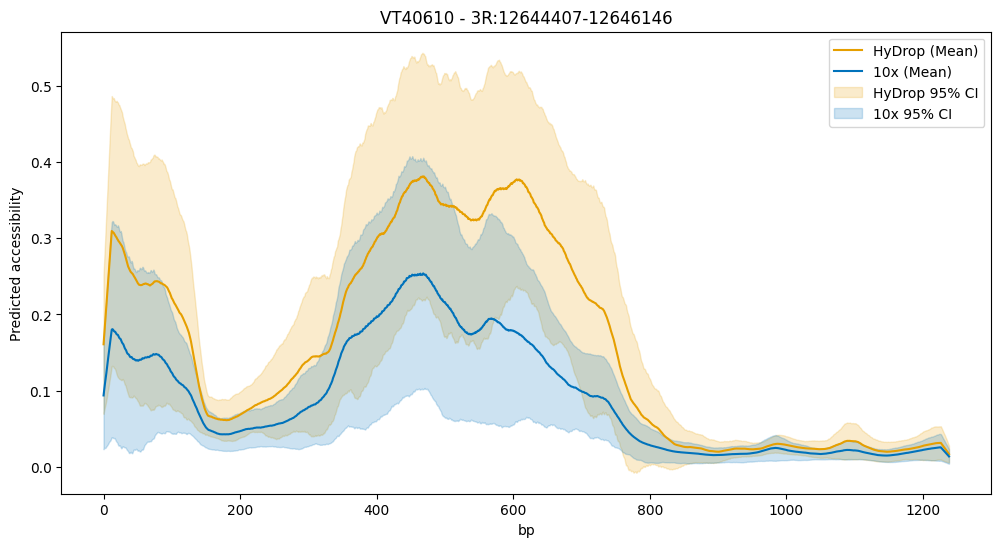

In [19]:
preds_multiome_folds = []
for model in multiome_models:
    _, _, _, preds_multiome = get_best_subregion(chrom, start, end, model, celltypes, adata, step=1)
    preds_multiome_folds.append(preds_multiome)

preds_hydrop_folds = []
for model in hydrop_models:
    _, _, _, preds_hydrop = get_best_subregion(chrom, start, end, model, celltypes, adata, step=1)
    preds_hydrop_folds.append(preds_hydrop)

plot_region_predictions_folds(preds_hydrop_folds, preds_multiome_folds, region_id, f"{chrom}:{str(start)}-{str(end)}", smooth_window=25)

## VT54783

In [20]:
region_id = "VT54783"
chrom = "X"
start = 337253
end = 339335
celltypes = ["Epidermis","Salivary_gland"]

In [21]:
best_chr_hydrop, best_start_hydrop, best_end_hydrop, preds_hydrop = get_best_subregion(chrom, start, end, hydrop_models, celltypes, adata, step=1)
best_subregion = f"{best_chr_hydrop}:{best_start_hydrop}-{best_end_hydrop}"
print(best_subregion)
best_subregions.append(best_subregion)

1582/1582 ━━━━━━━━━━━━━━━━━━━━ 1s 861us/step
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 1s 812us/step
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 1s 820us/step
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 1s 811us/step
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 1s 811us/step
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 1s 802us/step
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 1s 835us/step
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 1s 811us/step
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 1s 839us/step
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 1s 800us/step
X:337619-338119


1582/1582 ━━━━━━━━━━━━━━━━━━━━ 1s 811us/step
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 1s 802us/step
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 1s 797us/step
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 1s 808us/step
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 1s 821us/step
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 1s 828us/step
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 1s 804us/step
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 1s 810us/step
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 1s 810us/step
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 1s 815us/step
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 1s 854us/step
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 1s 820us/step
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 1s 805us/step
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 1s 808us/step
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 1s 819us/step
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 1s 815us/step
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 1s 813us/step
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 1s 806us/step
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 1s 842us/step
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 1s 799us/step


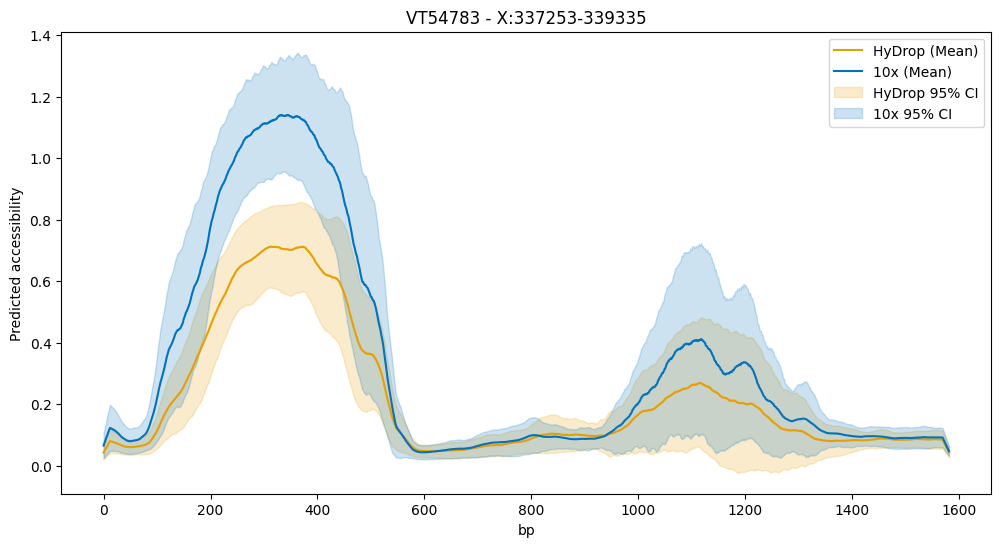

In [22]:
preds_multiome_folds = []
for model in multiome_models:
    _, _, _, preds_multiome = get_best_subregion(chrom, start, end, model, celltypes, adata, step=1)
    preds_multiome_folds.append(preds_multiome)

preds_hydrop_folds = []
for model in hydrop_models:
    _, _, _, preds_hydrop = get_best_subregion(chrom, start, end, model, celltypes, adata, step=1)
    preds_hydrop_folds.append(preds_hydrop)

plot_region_predictions_folds(preds_hydrop_folds, preds_multiome_folds, region_id, f"{chrom}:{str(start)}-{str(end)}", smooth_window=25)

## Best subregions: gt vs predicted

In [23]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [24]:
# save the best regions as a bed file and import adata
best_regions_df = pd.DataFrame(best_subregions, columns=["region"])
best_regions_df["chrom"] = best_regions_df["region"].str.split(":", expand=True)[0]
best_regions_df["start"] = best_regions_df["region"].str.split(":", expand=True)[1].str.split("-", expand=True)[0]
best_regions_df["end"] = best_regions_df["region"].str.split(":", expand=True)[1].str.split("-", expand=True)[1]
best_regions_df = best_regions_df[["chrom", "start", "end"]]
best_regions_df.to_csv("../data/stark_enhancers_best_regions.bed", sep="\t", index=False, header=False)

adata_best = crested.import_bigwigs(
    hydrop_coverage_bw_path,
    "../data/stark_enhancers_best_regions.bed",
    target="mean"
)

2025-03-19T21:19:25.761747+0100 INFO Extracting values from 20 bigWig files...


In [25]:
# change Obs_name "Pharnyx" to "Pharynx"
adata_best.obs_names = adata_best.obs_names.str.replace("Pharnyx", "Pharynx")

In [26]:
adata_best.layers["best_predict"] = crested.tl.predict(adata_best, hydrop_models).T

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [27]:
adata_best.var["VTID"] = ["VT14978", "VT3067", "VT40610", "VT54783"]

2025-03-19T21:19:28.405853+0100 INFO Plotting bar plots for region: 2R:11195867-11196367, models: ['best_predict']


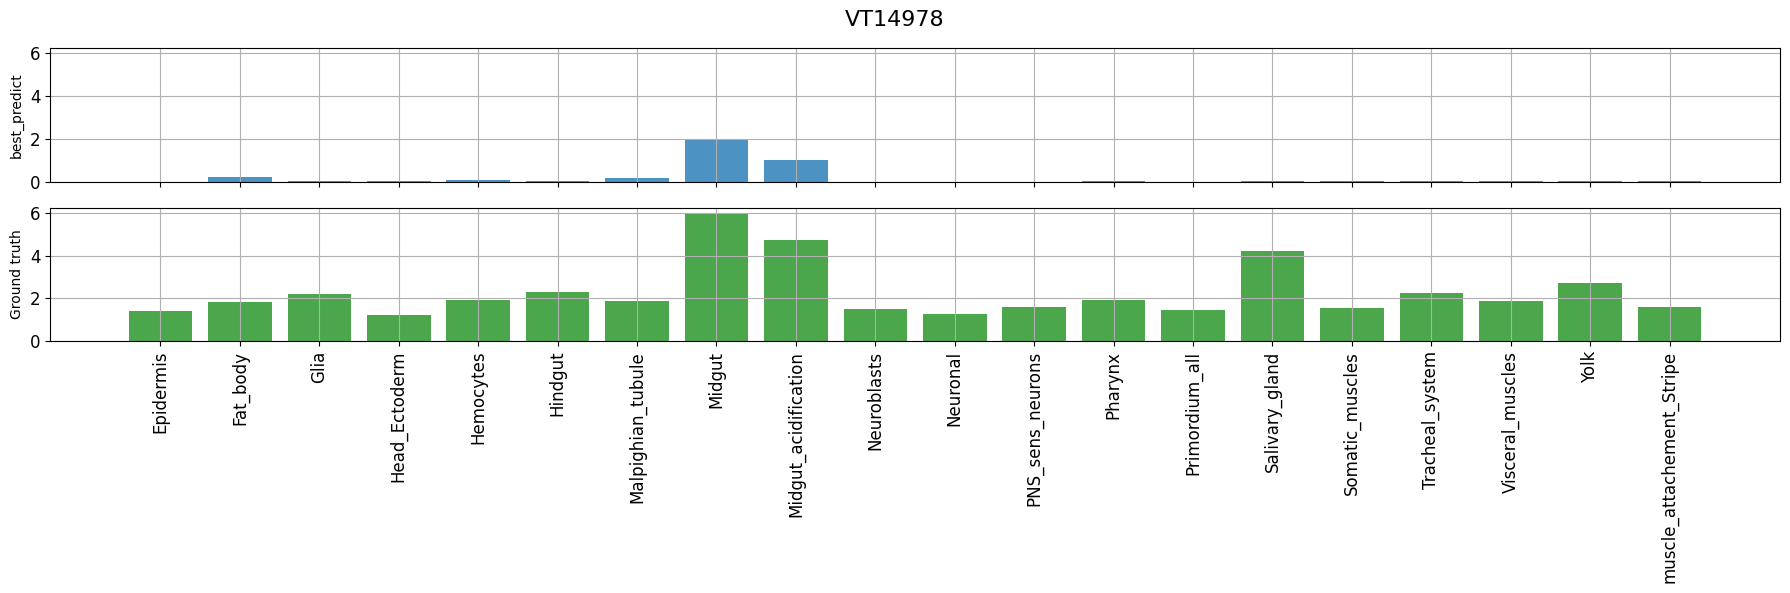

In [28]:
%matplotlib inline
idx = 0
crested.pl.bar.region_predictions(
    adata_best,
    region = list(adata_best.var_names)[idx],
    x_label_rotation=90,
    title=f"{list(adata_best.var["VTID"])[idx]}",
    save_path=f"../data/results/stark_enhancers_barplots/{list(adata_best.var["VTID"])[idx]}.pdf"
)

2025-03-19T21:19:29.052512+0100 INFO Plotting bar plots for region: 2L:6075201-6075701, models: ['best_predict']


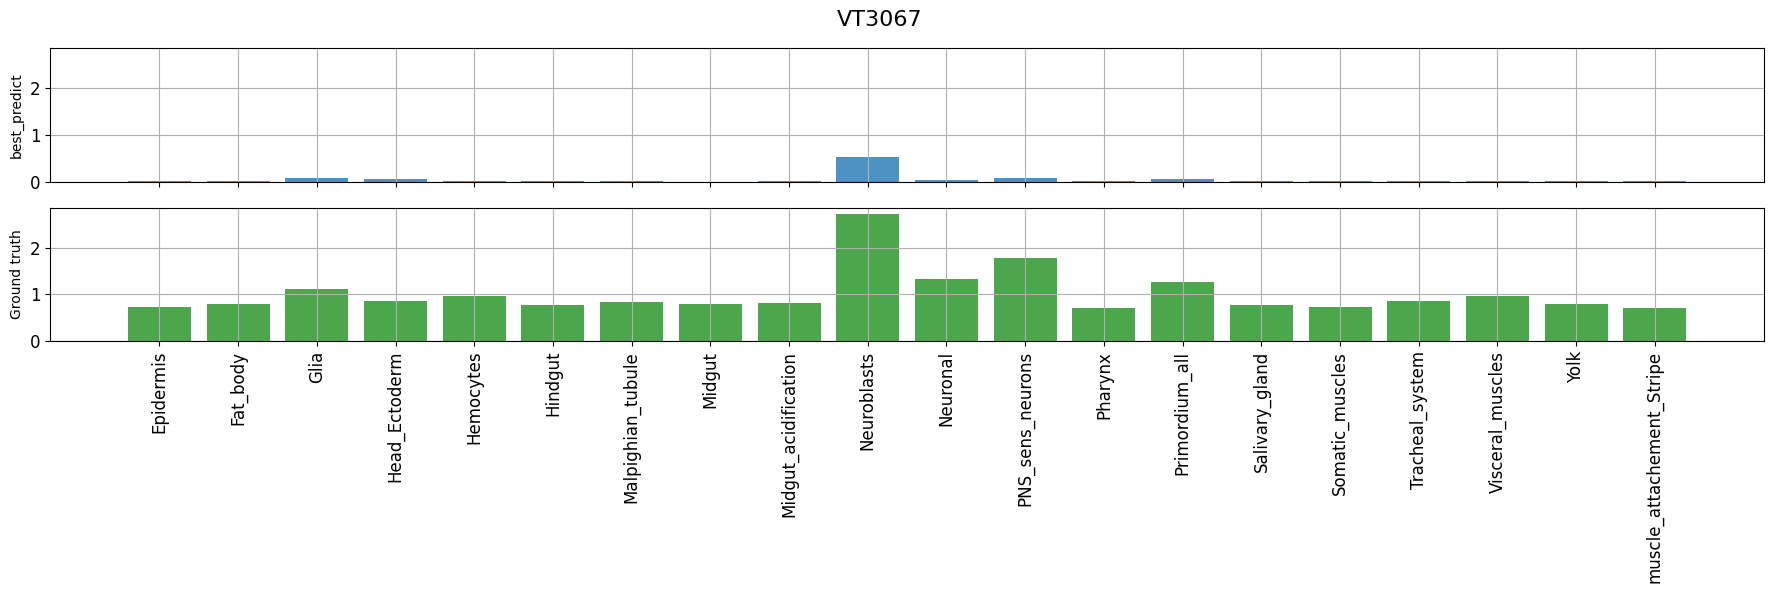

In [29]:
%matplotlib inline
idx = 1
crested.pl.bar.region_predictions(
    adata_best,
    region = list(adata_best.var_names)[idx],
    x_label_rotation=90,
    title=f"{list(adata_best.var["VTID"])[idx]}",
    save_path=f"../data/results/stark_enhancers_barplots/{list(adata_best.var["VTID"])[idx]}.pdf"
)

2025-03-19T21:19:29.872442+0100 INFO Plotting bar plots for region: 3R:12644887-12645387, models: ['best_predict']


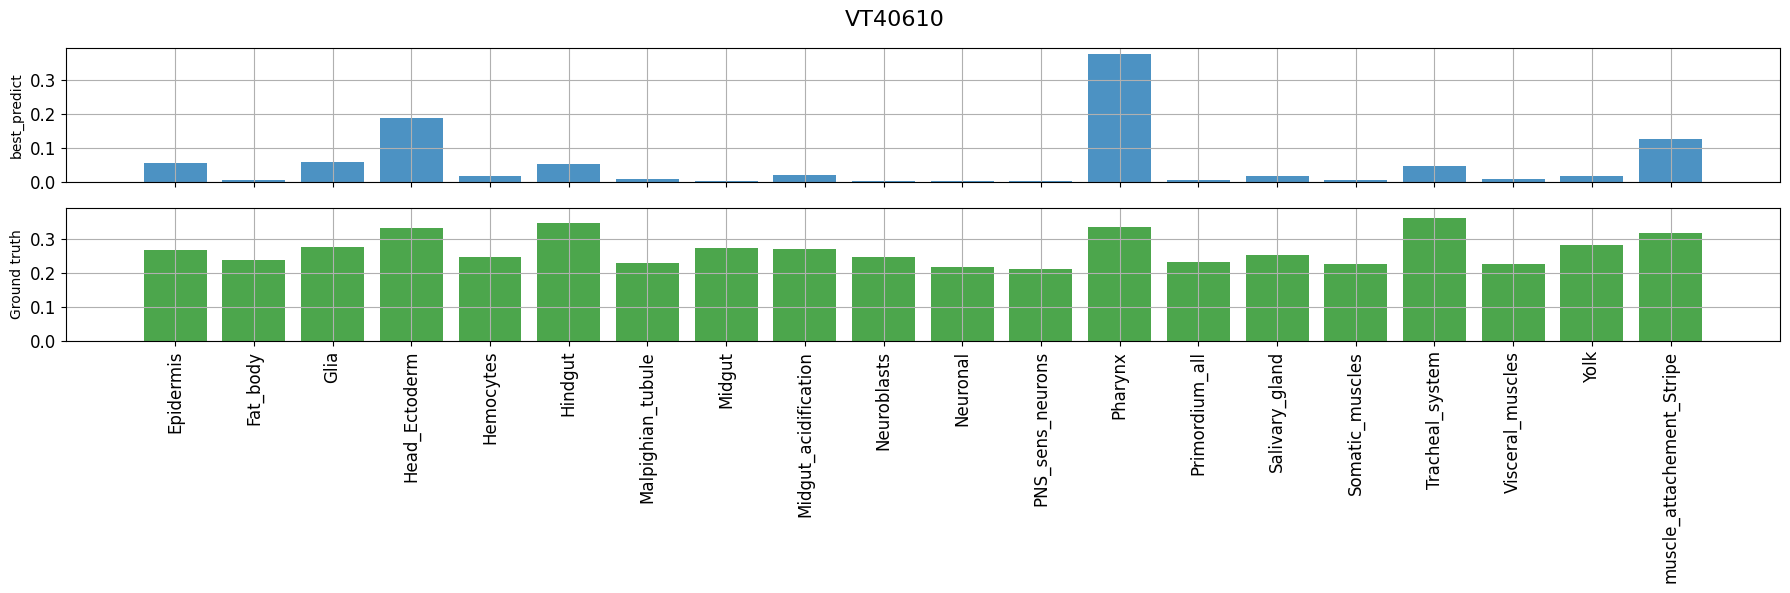

In [30]:
%matplotlib inline
idx = 2
crested.pl.bar.region_predictions(
    adata_best,
    region = list(adata_best.var_names)[idx],
    x_label_rotation=90,
    title=f"{list(adata_best.var["VTID"])[idx]}",
    save_path=f"../data/results/stark_enhancers_barplots/{list(adata_best.var["VTID"])[idx]}.pdf"
)

2025-03-19T21:25:02.291116+0100 INFO Plotting bar plots for region: X:337619-338119, models: ['best_predict']


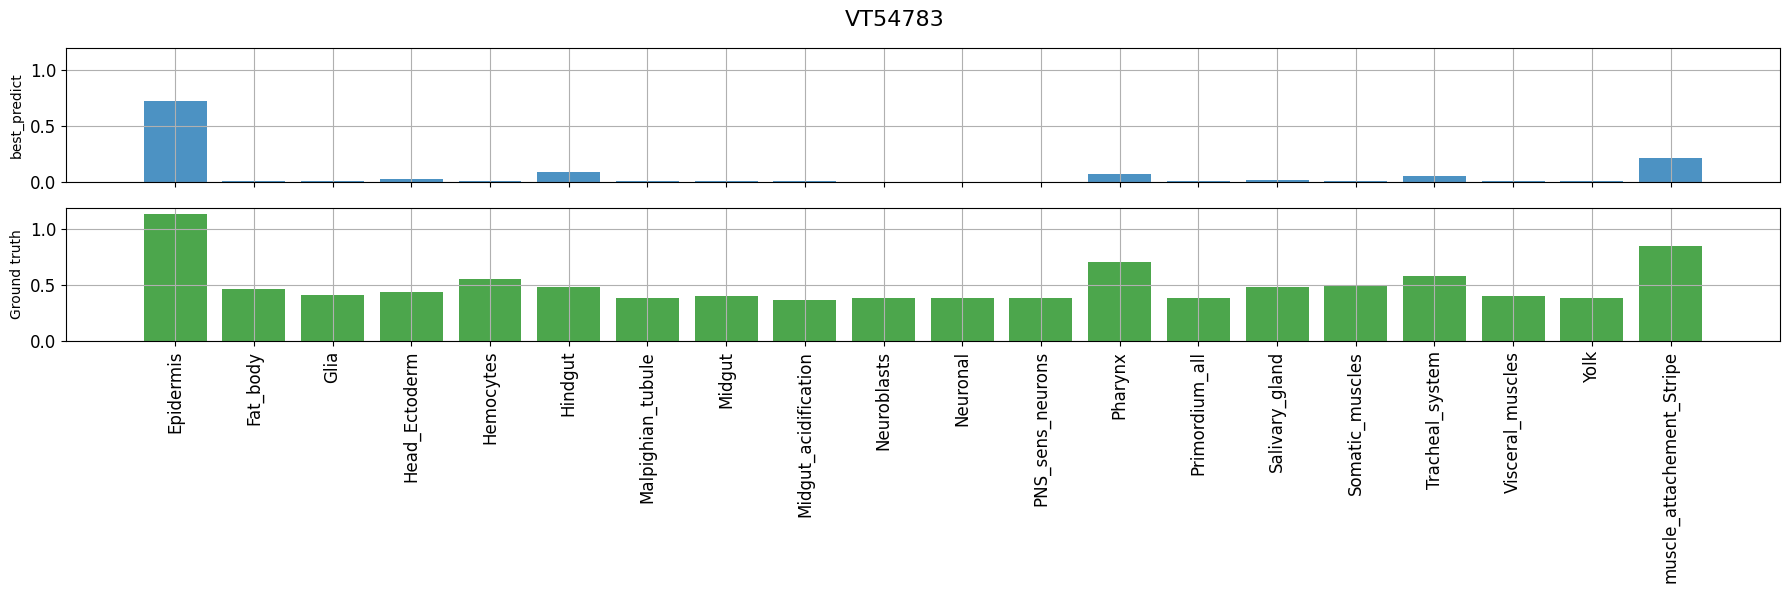

In [31]:
%matplotlib inline
idx = 3
crested.pl.bar.region_predictions(
    adata_best,
    region = list(adata_best.var_names)[idx],
    x_label_rotation=90,
    title=f"{list(adata_best.var["VTID"])[idx]}",
    save_path = f"../data/results/stark_enhancers_barplots/{list(adata_best.var["VTID"])[idx]}.pdf"
)